### 14-1. 프로젝트 : Segmentation map으로 도로 이미지 만들기

평가문항	상세기준
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.	데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.	U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.	10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.


### 1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.
(어떠한 방법을 사용했는지 적어주세요.)

1. 두이미지를 concatenate하고, padding후, crop
2. 좌우 반전
3. 위아래 반전
4. 회전


In [1]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.4
2.6.0


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import requests

url = 'https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip'

r = requests.get(url)
with open('./data/cityscapes.zip', 'wb') as f:
    f.write(r.content)

### 파일 압축 풀기

In [3]:
import zipfile

with zipfile.ZipFile('./data/cityscapes.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [4]:
import os

#data_train_path = os.getenv('HOME')+'/aiffel/workspace/EXPLORATION/Chapter_13_14/cityscapes/train'
#data_val_path = os.getenv('HOME')+'/aiffel/workspace/EXPLORATION/Chapter_13_14/cityscapes/val'

data_train_path = './data/cityscapes/train'
data_val_path = 'cityscapes/val'

print("number of train examples :", len(os.listdir(data_train_path)))
print("number of train examples :", len(os.listdir(data_val_path)))

number of train examples : 1000
number of train examples : 5


In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

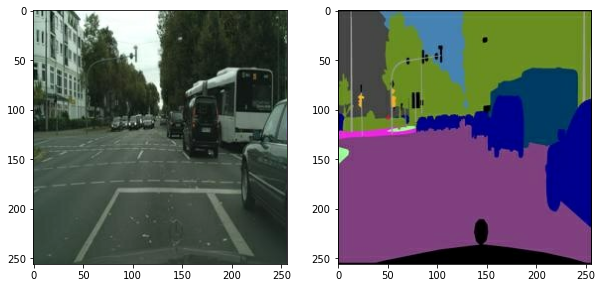

In [6]:
f = data_train_path + '/' + os.listdir(data_train_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [7]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

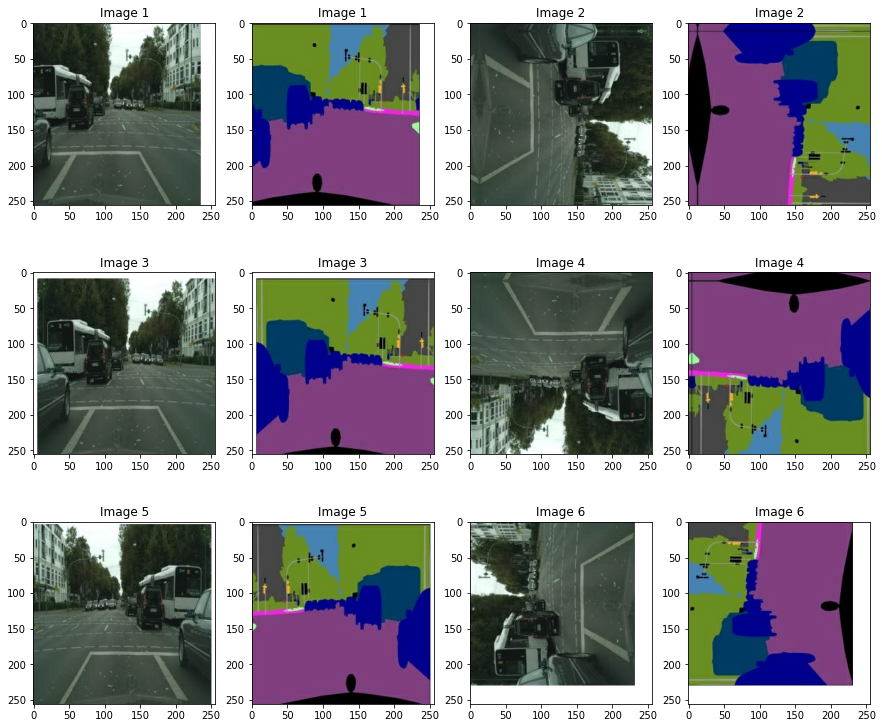

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

In [9]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

In [10]:
train_images = data.Dataset.list_files(f'{data_train_path}/*.jpg')
train_images = train_images.map(get_train).shuffle(100).batch(4)

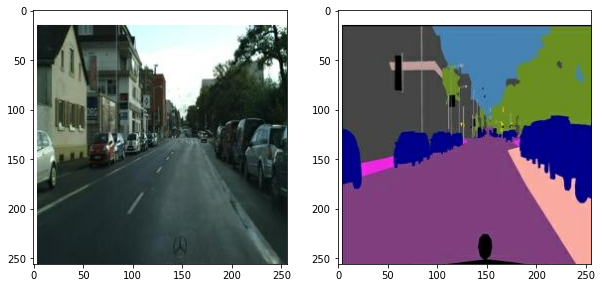

In [11]:
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(sketch[0].astype(np.uint8))

plt.subplot(1,2,2)
plt.imshow(colored[0].astype(np.uint8))

plt.show()

### 2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.

-  Encode block

In [12]:
from tensorflow.keras import Model, layers, Input

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [13]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

- UNet Generator

In [14]:


class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [15]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

- Discriminator Block

In [16]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [17]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


- Discriminator

In [18]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
                 
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        
        for i, fts in enumerate(filters):   #hjnam
            self.blocks.append(DiscBlock(
                n_filters = fts,
                stride = 1 if i > 2 else 1,
                custom_pad = False if i > 3 else True,
                use_bn = False if i == 1 or i == 5 else True,
                act = True if i >= 4 else False
                ))
        self.sigmoid = layers.Activation('sigmoid')       
            
    
    def call(self, x, y):
        out = self.blocks[0]([x,y]) #hjnam
        for i in range(1,6):
            out = self.blocks[i](out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    

In [19]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 255, 255, 64) 6400        concatenate_7[0][0]        

### 3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 
- 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.

In [20]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [21]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [22]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
    
        fake_colored = generator(sketch, training = True)

        fake_disc = discriminator(sketch, fake_colored, training = True)
        real_disc = discriminator(sketch, real_colored, training = True)

        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss+(100*l1_loss)

        disc_loss = get_disc_loss(fake_disc, real_disc)

    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [23]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.5919                     
L1_loss:0.3531                     
Discriminator_loss:1.4397

EPOCH[1] - STEP[20]                     
Generator_loss:0.6184                     
L1_loss:0.2596                     
Discriminator_loss:1.4048

EPOCH[1] - STEP[30]                     
Generator_loss:0.6159                     
L1_loss:0.3069                     
Discriminator_loss:1.4257

EPOCH[1] - STEP[40]                     
Generator_loss:0.5886                     
L1_loss:0.2566                     
Discriminator_loss:1.4249

EPOCH[1] - STEP[50]                     
Generator_loss:0.5947                     
L1_loss:0.2694                     
Discriminator_loss:1.4136

EPOCH[1] - STEP[60]                     
Generator_loss:0.6322                     
L1_loss:0.2849                     
Discriminator_loss:1.3941

EPOCH[1] - STEP[70]                     
Generator_loss:0.6081                     
L1_loss:0.2728                    

EPOCH[3] - STEP[70]                     
Generator_loss:0.6562                     
L1_loss:0.2246                     
Discriminator_loss:1.3951

EPOCH[3] - STEP[80]                     
Generator_loss:0.6694                     
L1_loss:0.1783                     
Discriminator_loss:1.3861

EPOCH[3] - STEP[90]                     
Generator_loss:0.6737                     
L1_loss:0.1765                     
Discriminator_loss:1.3806

EPOCH[3] - STEP[100]                     
Generator_loss:0.6682                     
L1_loss:0.1948                     
Discriminator_loss:1.4076

EPOCH[3] - STEP[110]                     
Generator_loss:0.6766                     
L1_loss:0.1915                     
Discriminator_loss:1.3730

EPOCH[3] - STEP[120]                     
Generator_loss:0.6582                     
L1_loss:0.2220                     
Discriminator_loss:1.3967

EPOCH[3] - STEP[130]                     
Generator_loss:0.6905                     
L1_loss:0.1821                

EPOCH[5] - STEP[130]                     
Generator_loss:0.6911                     
L1_loss:0.1806                     
Discriminator_loss:1.3462

EPOCH[5] - STEP[140]                     
Generator_loss:0.6717                     
L1_loss:0.1785                     
Discriminator_loss:1.4026

EPOCH[5] - STEP[150]                     
Generator_loss:0.7031                     
L1_loss:0.1549                     
Discriminator_loss:1.3664

EPOCH[5] - STEP[160]                     
Generator_loss:0.6905                     
L1_loss:0.1304                     
Discriminator_loss:1.3546

EPOCH[5] - STEP[170]                     
Generator_loss:0.6979                     
L1_loss:0.1930                     
Discriminator_loss:1.3720

EPOCH[5] - STEP[180]                     
Generator_loss:0.6973                     
L1_loss:0.2067                     
Discriminator_loss:1.3562

EPOCH[5] - STEP[190]                     
Generator_loss:0.7050                     
L1_loss:0.1359             

EPOCH[7] - STEP[190]                     
Generator_loss:0.7043                     
L1_loss:0.1957                     
Discriminator_loss:1.3459

EPOCH[7] - STEP[200]                     
Generator_loss:0.7064                     
L1_loss:0.1944                     
Discriminator_loss:1.3392

EPOCH[7] - STEP[210]                     
Generator_loss:0.7058                     
L1_loss:0.1707                     
Discriminator_loss:1.3333

EPOCH[7] - STEP[220]                     
Generator_loss:0.7008                     
L1_loss:0.1445                     
Discriminator_loss:1.3448

EPOCH[7] - STEP[230]                     
Generator_loss:0.6993                     
L1_loss:0.1918                     
Discriminator_loss:1.3472

EPOCH[7] - STEP[240]                     
Generator_loss:0.6950                     
L1_loss:0.1963                     
Discriminator_loss:1.3524

EPOCH[7] - STEP[250]                     
Generator_loss:0.6551                     
L1_loss:0.1669             

EPOCH[9] - STEP[250]                     
Generator_loss:0.6968                     
L1_loss:0.1599                     
Discriminator_loss:1.3297

EPOCH[10] - STEP[10]                     
Generator_loss:0.6925                     
L1_loss:0.1576                     
Discriminator_loss:1.3285

EPOCH[10] - STEP[20]                     
Generator_loss:0.7050                     
L1_loss:0.1505                     
Discriminator_loss:1.3100

EPOCH[10] - STEP[30]                     
Generator_loss:0.6925                     
L1_loss:0.1256                     
Discriminator_loss:1.3667

EPOCH[10] - STEP[40]                     
Generator_loss:0.6813                     
L1_loss:0.1412                     
Discriminator_loss:1.3861

EPOCH[10] - STEP[50]                     
Generator_loss:0.6910                     
L1_loss:0.1625                     
Discriminator_loss:1.3394

EPOCH[10] - STEP[60]                     
Generator_loss:0.7063                     
L1_loss:0.1498             

### 4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 
 - 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.

Text(0.5, 1.0, 'Colored Image')

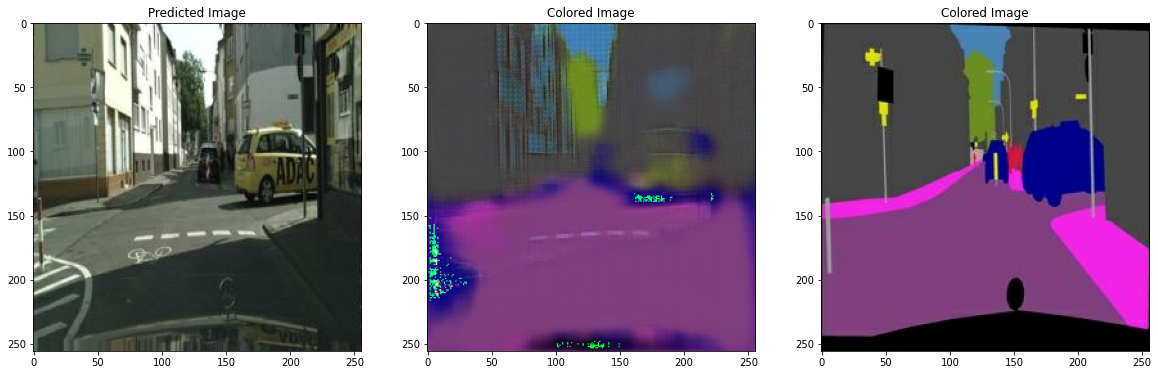

In [35]:
test_ind = 1

f = data_val_path + '/' + os.listdir(data_val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

title_list =['Sketch Image', 'Predicted Image', 'Colored Image']
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch));plt.title(title_list[1])
plt.subplot(1,3,2); plt.imshow(pred[0]);plt.title(title_list[2])
plt.subplot(1,3,3); plt.imshow(denormalize(colored));plt.title(title_list[2])

### 5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 
- 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.